## Current Python Version

Ensure the python version running in the jupyter kernel is the same as expected

In [1]:
# from platform import python_version

# print(python_version())


List installed packages, should match the ones in the pipfile (and their dependencies)

In [2]:
# pip list

## Internal Module Imports
Code required to enable project's internally defined modulos into the jupyter notebook environment

In [3]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [4]:
# from electricity import ElectricalSystem, Load, Generator
from dto import (
    COST_PRESETS, 
    ElectricalSystemSpecs, 
    EpsilonSpecs,
    GeneratorSpecs, 
    LoadSpecs, 
    NodeStatePower, 
    SystemHistory, 
    )
    
from learning import ModelTrainer, ModelTester, LearningParams

/home/fmello/.local/share/virtualenvs/2019-MSc_Thesis-4pUnri4s/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/fmello/.local/share/virtualenvs/2019-MSc_Thesis-4pUnri4s/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/fmello/.local/share/virtualenvs/2019-MSc_Thesis-4pUnri4s/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 

Determine the experiment params

In [5]:
from dto import EpsilonSpecs, ElectricalConstants
import math

LearningParams(
    gamma=0.9,   # Gamma (Discount)
    tau=0.001, # Tau
    epsilonSpecs = EpsilonSpecs( # Epsilon explore/exploit control
        thresholdProgress = 0.6, # % of steps where decay change should happen
        thresholdValue = 0.5, # Value at which decay change would happen
        finalValue = 0.0001, # Value at the end of the experiment
    ),
    numEpisodes=5000, # Number of learning episodes to run
    maxSteps=100,   # Number of steps per learning episode
    bufferSize=500, # Experience Buffer Size
    traceLength=20,     # Number of steps each sampled episode should contain
    batchSize=10,     # Number of episodes sampled from experience buffer
    updateInterval=4, # Run update cycle every N steps
    electricalSystemSpecs = ElectricalSystemSpecs(
        loads=[LoadSpecs(id_="L1", basePower=3.0, noiseLevel=0.01)],
        generators=[
            GeneratorSpecs(id_="G1", basePower=1.0, costProfile=COST_PRESETS.COAL_2, minPower=0.5, maxPower=3.0, noiseLevel=0.005),
            GeneratorSpecs(id_="G2", basePower=1.0, costProfile=COST_PRESETS.OIL_2, minPower=0.5, maxPower=3.0, noiseLevel=0.005),
            GeneratorSpecs(id_="G3", basePower=1.0, costProfile=COST_PRESETS.OIL_ALTERNATE_2, minPower=0.5, maxPower=3.0, noiseLevel=0.005),
        ],
        shouldTrackOptimalCost=True,
    ),
    modelName='Pico-3Gens-Cost-5k-PF2-c3-Scaled'
)

# Droop = +infinity essentially remove the droop component from the power update equation. System reacts as if droop is disabled
# ElectricalConstants().droop = math.inf

LearningParams(electricalSystemSpecs=ElectricalSystemSpecs(loads=[LoadSpecs(id_='L1', basePower=3.0, noiseLevel=0.01)], generators=[GeneratorSpecs(id_='G1', basePower=1.0, costProfile=CostProfile(alpha=510.0, beta=7.7, gamma=0.00142), minPower=0.5, maxPower=3.0, noiseLevel=0.005), GeneratorSpecs(id_='G2', basePower=1.0, costProfile=CostProfile(alpha=310.0, beta=7.85, gamma=0.00194), minPower=0.5, maxPower=3.0, noiseLevel=0.005), GeneratorSpecs(id_='G3', basePower=1.0, costProfile=CostProfile(alpha=78.0, beta=7.55, gamma=0.00482), minPower=0.5, maxPower=3.0, noiseLevel=0.005)], shouldTrackOptimalCost=True), gamma=0.9, tau=0.001, epsilonSpecs=EpsilonSpecs(thresholdProgress=0.6, thresholdValue=0.5, finalValue=0.0001), numEpisodes=500, maxSteps=100, bufferSize=500, traceLength=20, batchSize=10, updateInterval=4, nnShape=NeuralNetworkShape(layer_00_ltsm=100, layer_01_mlp_01=1000, layer_02_mlp_02=100, layer_03_mlp_03=50, layer_04_mlp_04=1), explorationNoiseSize=0.4, actionScale=0.1, modelNam

Train Agents

In [23]:
def rewardFn(totalCost, outputDifferential):
#     scaledCost = totalCost/(100000.0) # Scale down cost to levels near the ones found in output differential (e.g. 0.1 */ 0.01)
    minCost = 2073.45
    maxCost = 8564.2
    scaledCost = (totalCost-minCost)/(maxCost-minCost)
    scaledOutputDifferential = outputDifferential*10
    costComponent = 2**(-1*(scaledCost**2))
    outputComponent = 2**(-1*(scaledOutputDifferential**2))
    earnedReward = costComponent*outputComponent
    
#     print(f'Scaled_Cost:{scaledCost} - OutputDiff:{scaledOutputDifferential} - costComponent:{costComponent} - outputComponent:{outputComponent} - reward:{earnedReward}')

    return earnedReward, {'cost': costComponent, 'output': outputComponent, 'total':earnedReward}

In [22]:
from learning.cost import ModelAdapterCost as ModelAdapter
modelAdapter = ModelAdapter(rewardFn=rewardFn)

In [8]:
%%time
allAgents = ModelTrainer(modelAdapter).trainAgents()

W0920 23:52:16.559166 139788040210176 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W0920 23:52:16.561700 139788040210176 deprecation.py:323] From /mnt/c/Users/flavi/Documents/Study/City-UniLondon/Thesis/2019-MSc_Thesis/app/learning/actor.py:29: BasicLSTMCell.__init__ (from tensorflow.python.ops.rnn_cell_impl) is deprecated and will be removed in a future version.
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
W0920 23:52:16.596037 139788040210176 deprecation.py:323] From /mnt/c/Users/flavi/Documents/Study/City-UniLondon/Thesis/2019-MSc_Thesis/app/learning/actor.py:38: dyna

Training model: Pico-3Gens-Cost-0_5k-PF2-Scaled - 0% 1% 2% 3% 4% 5% 6% 7% 8% 9% 10% 11% 12% 13% 14% 15% 16% 17% 18% 19% 20% 21% 22% 23% 24% 25% 26% 27% 28% 29% 30% 31% 32% 33% 34% 35% 36% 37% 38% 39% 40% 41% 42% 43% 44% 45% 46% 47% 48% 49% 50% 51% 52% 53% 54% 55% 56% 57% 58% 59% 60% 61% 62% 63% 64% 65% 66% 67% 68% 69% 70% 71% 72% 73% 74% 75% 76% 77% 78% 79% 80% 81% 82% 83% 84% 85% 86% 87% 88% 89% 90% 91% 92% 93% 94% 95% 96% 97% 98% 99% 100%
Model saved in path: /mnt/c/Users/flavi/Documents/Study/City-UniLondon/Thesis/2019-MSc_Thesis/app/models/Pico-3Gens-Cost-0_5k-PF2-Scaled/model
CPU times: user 1h 58min 7s, sys: 12min 29s, total: 2h 10min 36s
Wall time: 1h 23min 16s


In [24]:
STEPS_TO_TEST = 300

# testSpecs = ElectricalSystemSpecs(
#         loads=[LoadSpecs(id_="L1", basePower=3.0, noiseLevel=0.1)],
#         generators=[
#             GeneratorSpecs(id_="G1", basePower=1.5, costProfile=COST_PRESETS.COAL, minPower=0.5, maxPower=2.0, noiseLevel=0.0),
#             GeneratorSpecs(id_="G2", basePower=1.5, costProfile=COST_PRESETS.OIL, minPower=0.5, maxPower=2.0, noiseLevel=0.0),
#         ],
# )
# electricalSystem, rewards = ModelTester.testAgents(testSpecs, LearningParams().modelName, STEPS_TO_TEST)


electricalSystem, rewards = ModelTester(modelAdapter).testAgents(LearningParams().electricalSystemSpecs, LearningParams().modelName, STEPS_TO_TEST)

Scaled_Cost:0.17660074450165267 - OutputDiff:-3.03393426516722 - costComponent:0.9786142373396489 - outputComponent:0.00169469677293082 - reward:0.0016584543899636585
Scaled_Cost:0.16438469344350476 - OutputDiff:-6.324636150654646 - costComponent:0.9814438747132144 - outputComponent:9.088503711022391e-13 - reward:8.919856297491244e-13
Scaled_Cost:0.15270345679064026 - OutputDiff:-9.540955701375642 - costComponent:0.9839668755177295 - outputComponent:3.9562976243349708e-28 - reward:3.8928658120350972e-28
Scaled_Cost:0.15752350113138341 - OutputDiff:-8.467357808869547 - costComponent:0.9829475533706042 - outputComponent:2.6140193563933404e-22 - reward:2.5694439308302355e-22
Scaled_Cost:0.18087685525706734 - OutputDiff:-2.4702708208849735 - costComponent:0.9775778914948999 - outputComponent:0.014556043434813502 - reward:0.014229666249513164
Scaled_Cost:0.21889868067696722 - OutputDiff:7.48721797352736 - costComponent:0.9673322262738403 - outputComponent:1.3326931398685656e-17 - reward:1.2

Scaled_Cost:0.2026503605532713 - OutputDiff:2.521181363691776 - costComponent:0.9719357357887358 - outputComponent:0.01220524048263235 - reward:0.011862709388965739
Scaled_Cost:0.1908146698836015 - OutputDiff:-0.6434915090976688 - costComponent:0.9750781532848234 - outputComponent:0.7504972433038514 - reward:0.7317934660460702
Scaled_Cost:0.19084664522444966 - OutputDiff:-0.6354819094765719 - costComponent:0.9750699051381466 - outputComponent:0.7558452222148998 - reward:0.7370019291242037
Scaled_Cost:0.19086476497320906 - OutputDiff:-0.6309430774547697 - costComponent:0.9750652305055162 - outputComponent:0.7588627228846961 - reward:0.73994065581161
Scaled_Cost:0.19086847526871326 - OutputDiff:-0.6300136856634975 - costComponent:0.9750642732510593 - outputComponent:0.7594794089176273 - reward:0.7405412379054104
Scaled_Cost:0.1908599536893208 - OutputDiff:-0.632148257528003 - costComponent:0.9750664717881362 - outputComponent:0.7580624349355306 - reward:0.7391612638277114
Scaled_Cost:0.1

Scaled_Cost:0.19080547316093383 - OutputDiff:-0.6457952399825131 - costComponent:0.9750805253673572 - outputComponent:0.7489537354351359 - reward:0.730290201823937
Scaled_Cost:0.19080543654758592 - OutputDiff:-0.6458044114488455 - costComponent:0.9750805348107091 - outputComponent:0.7489475858564258 - reward:0.7302842125620732
Scaled_Cost:0.20208508271881018 - OutputDiff:2.3703763718441975 - costComponent:0.9720898812146695 - outputComponent:0.02035202073497872 - reward:0.019783993418743956
Scaled_Cost:0.21461806456873453 - OutputDiff:5.684069737684265 - costComponent:0.9685772929792025 - outputComponent:1.8798690466920177e-10 - reward:1.8207984724003484e-10
Scaled_Cost:0.22734098837242728 - OutputDiff:9.00883202344265 - costComponent:0.964809538174998 - outputComponent:3.7041639254593897e-25 - reward:3.5738126862469615e-25
Scaled_Cost:0.24021695780263505 - OutputDiff:12.334806925901676 - costComponent:0.9607918465112966 - outputComponent:1.5814308411420602e-46 - reward:1.5194258579907

Scaled_Cost:0.19080540230916193 - OutputDiff:-0.6458129880083412 - costComponent:0.9750805436415165 - outputComponent:0.7489418351365865 - reward:0.7302786117608578
Scaled_Cost:0.20264321441510974 - OutputDiff:2.5187783966041772 - costComponent:0.9719376870012599 - outputComponent:0.012308129929921613 - reward:0.011962735335398992
Scaled_Cost:0.21519877676820146 - OutputDiff:5.836670113134727 - costComponent:0.968409734444276 - outputComponent:5.5577118382697567e-11 - reward:5.3821422454166244e-11
Scaled_Cost:0.22792999778418163 - OutputDiff:9.161819038208034 - costComponent:0.9646302222352449 - outputComponent:5.393427452448142e-26 - reward:5.202663122064722e-26
Scaled_Cost:0.24081301999285554 - OutputDiff:12.487851894424994 - costComponent:0.9606009160019405 - outputComponent:1.1361674859273855e-47 - reward:1.0914035277134684e-47
Scaled_Cost:0.2538440968793122 - OutputDiff:15.813787780966246 - costComponent:0.9563185559315375 - outputComponent:5.2439401866306594e-76 - reward:5.014877

Scaled_Cost:0.24114357830182026 - OutputDiff:12.572691486605974 - costComponent:0.9604948440680361 - outputComponent:2.6026428265764808e-48 - reward:2.4998250158773696e-48
Scaled_Cost:0.25418006880136235 - OutputDiff:15.89904028747679 - costComponent:0.956205422825946 - outputComponent:8.04995792977143e-77 - reward:7.697413425968167e-77
Scaled_Cost:0.2673574311571654 - OutputDiff:19.223484199381673 - costComponent:0.9516612306382801 - outputComponent:5.710439807262153e-112 - reward:5.434404174464923e-112
Scaled_Cost:0.2756970527903545 - OutputDiff:21.308352849307262 - costComponent:0.94867848578504 - outputComponent:2.082400912427206e-137 - reward:1.9755289443988275e-137
Scaled_Cost:0.26243575742207476 - OutputDiff:17.986193277236094 - costComponent:0.9533827802834468 - outputComponent:4.1290351294100126e-98 - reward:3.936550991564939e-98
Scaled_Cost:0.24930373661027946 - OutputDiff:14.659239506553433 - costComponent:0.9578340626225881 - outputComponent:2.04489002591025e-65 - reward:1.

Alternatively, one can plot the data to better inspect the progression

In [10]:
    import matplotlib.pyplot as plt
from learning.learning_state import LearningState
from plots import plotAll, plotExperimentRewardProgression

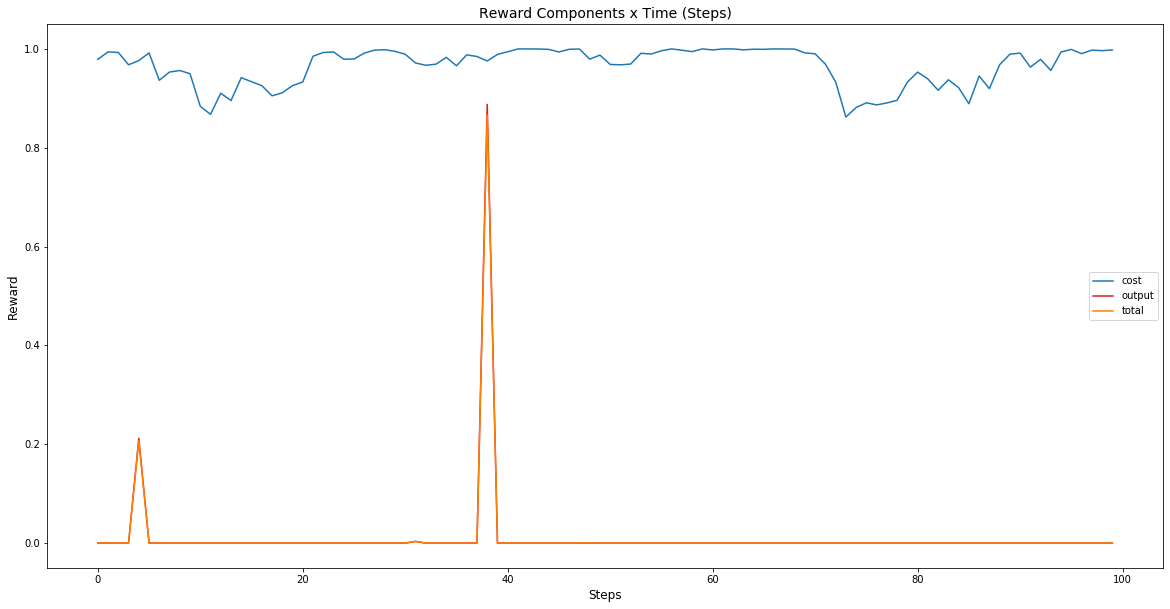

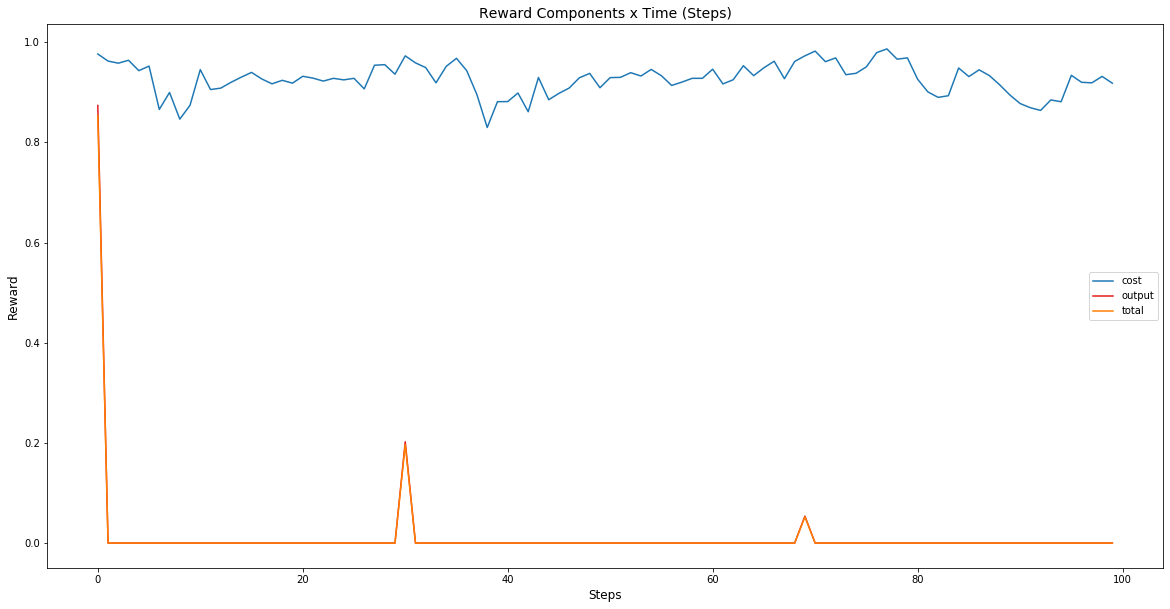

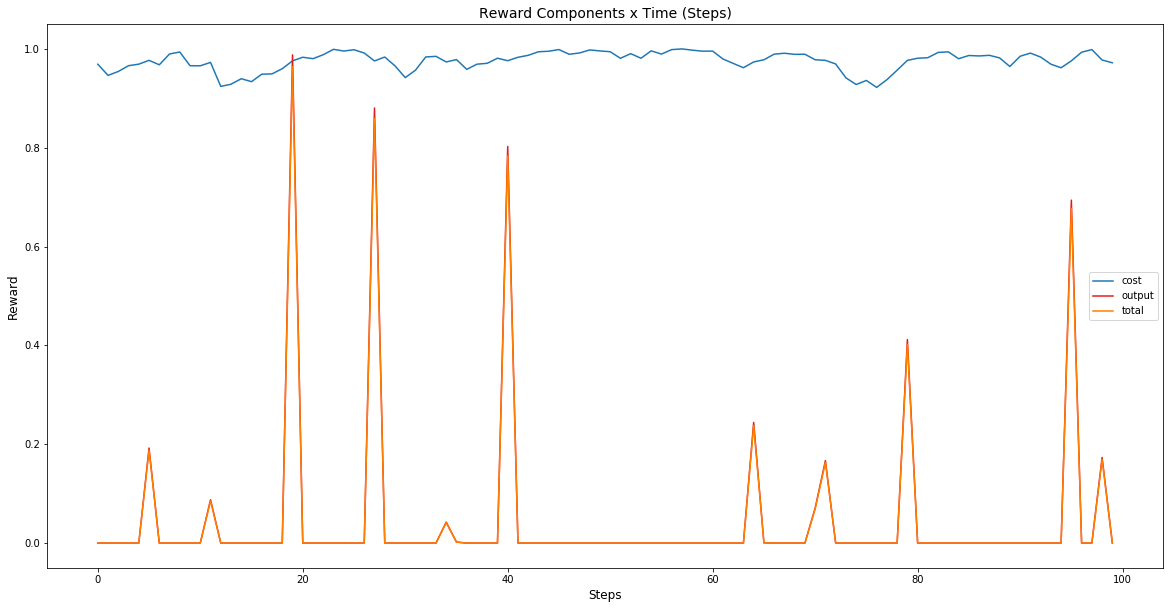

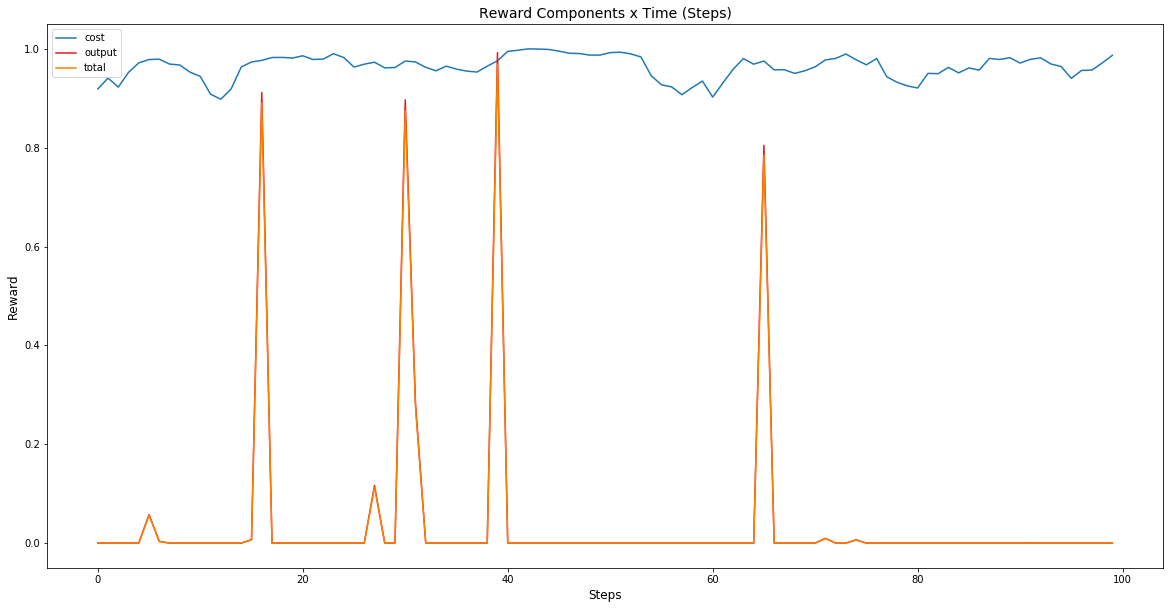

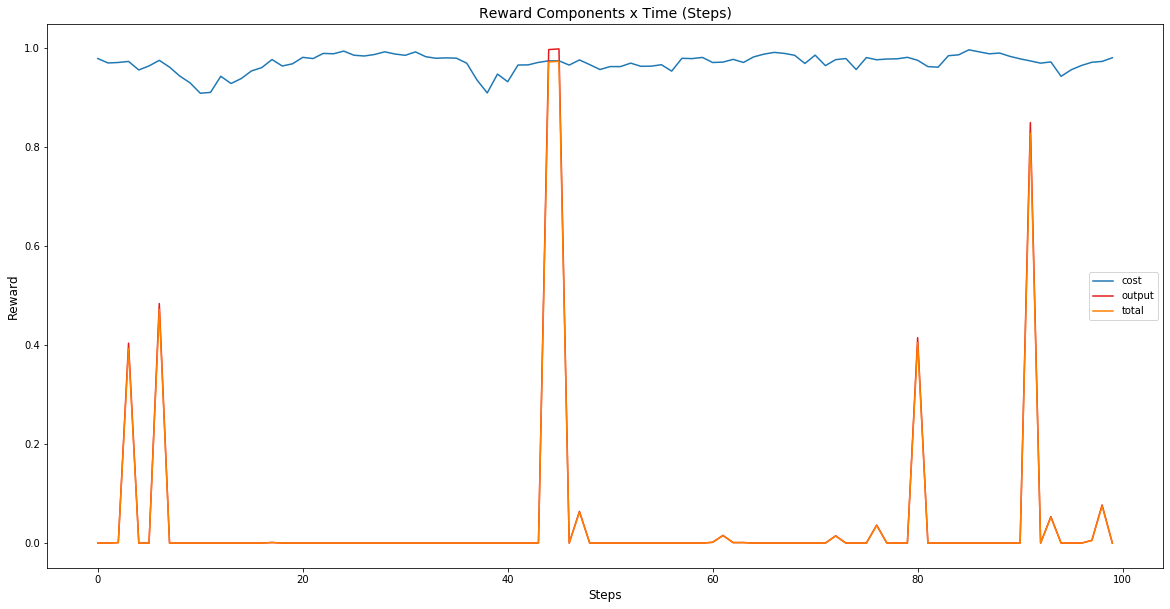

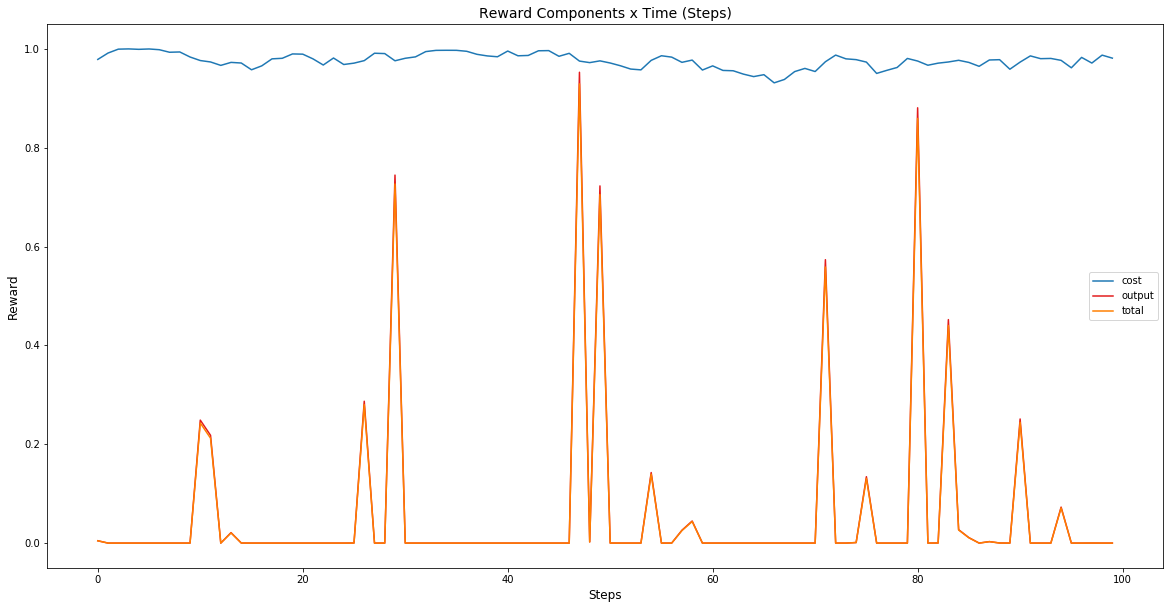

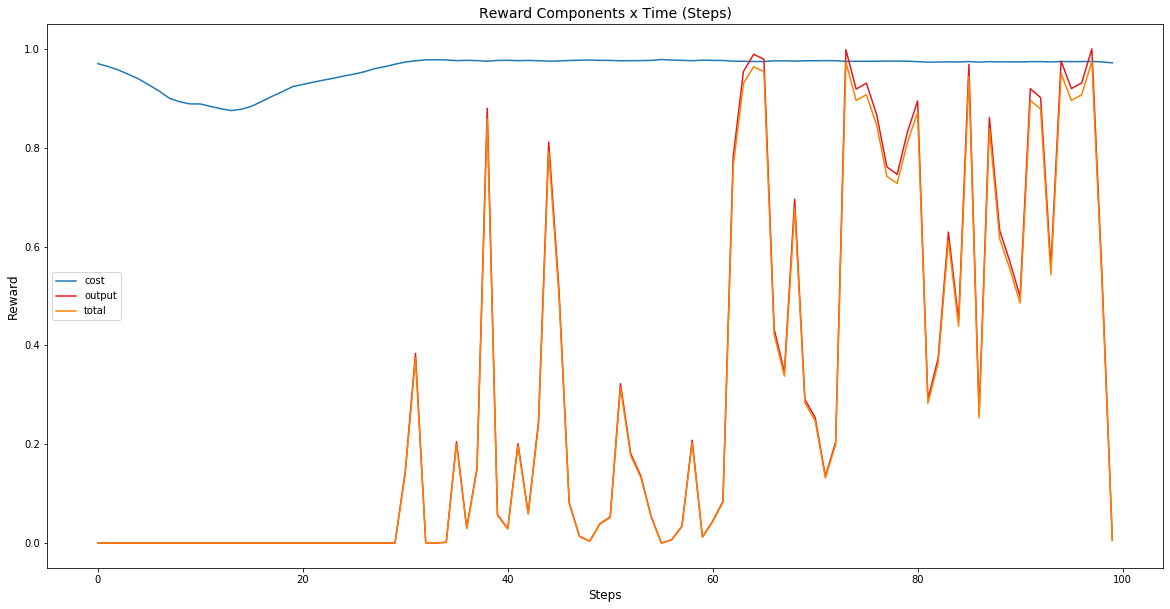

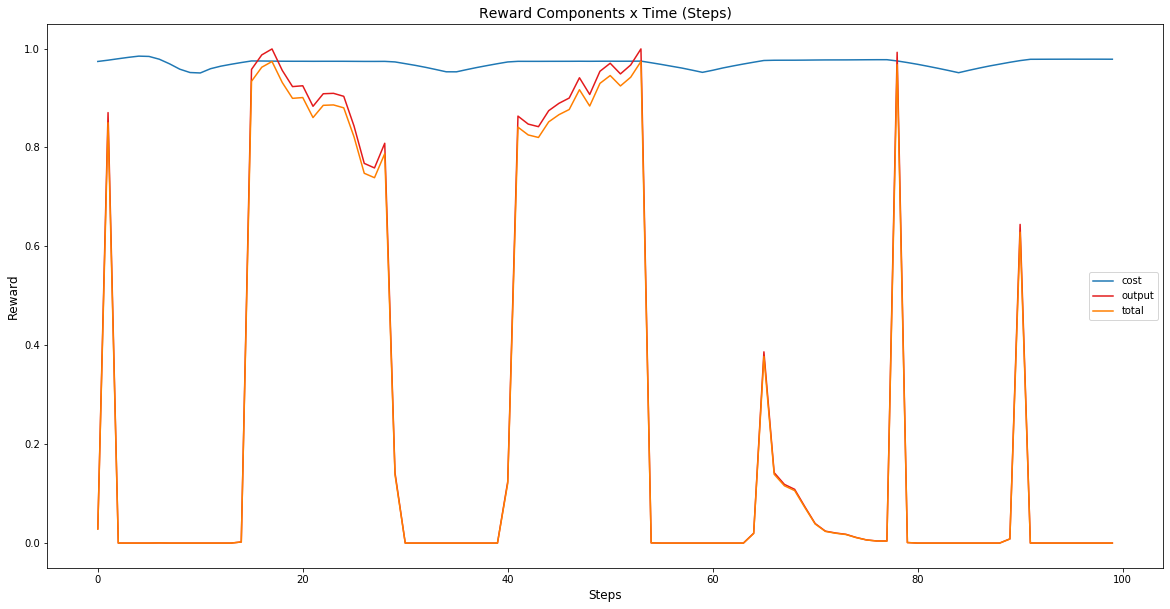

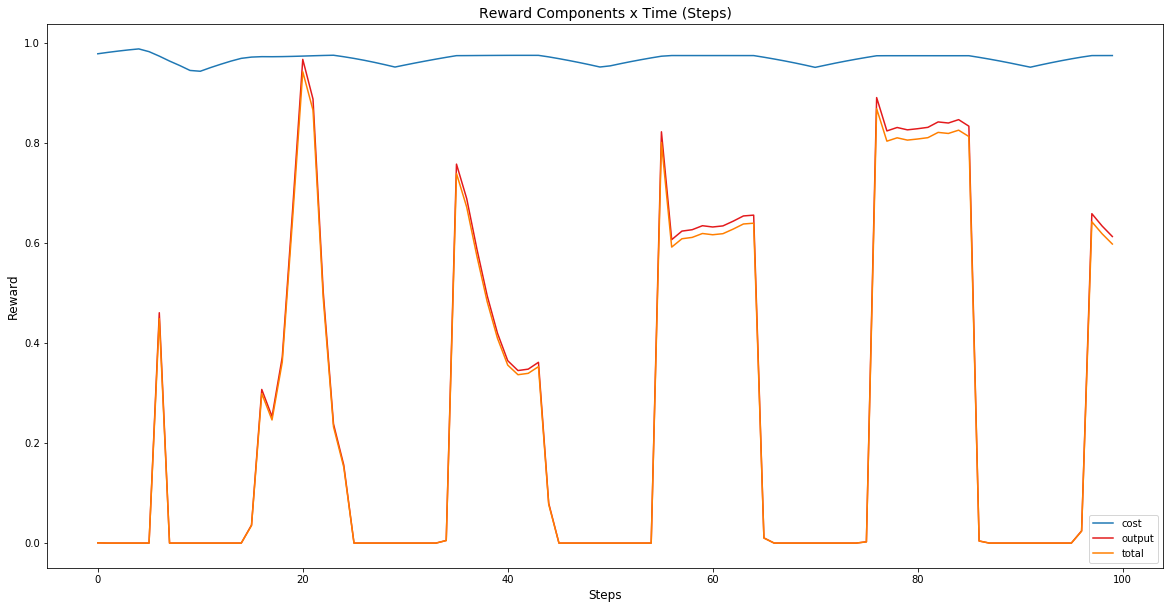

In [11]:
plotExperimentRewardProgression(LearningState().model.allRewards)

Plot the reward progression of the model testing

86.89317861096099

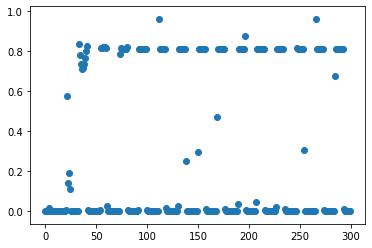

In [12]:
steps = range(STEPS_TO_TEST)
plt.scatter(steps, rewards)
sum(rewards)

Plot all graphs related to the electrical system state during the model testing

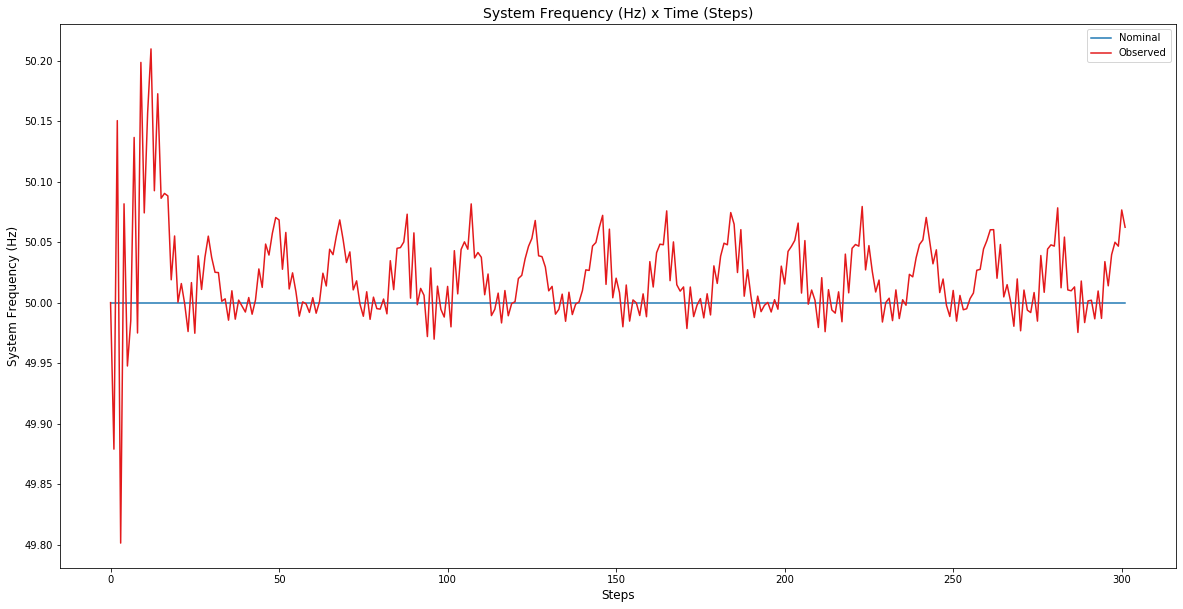

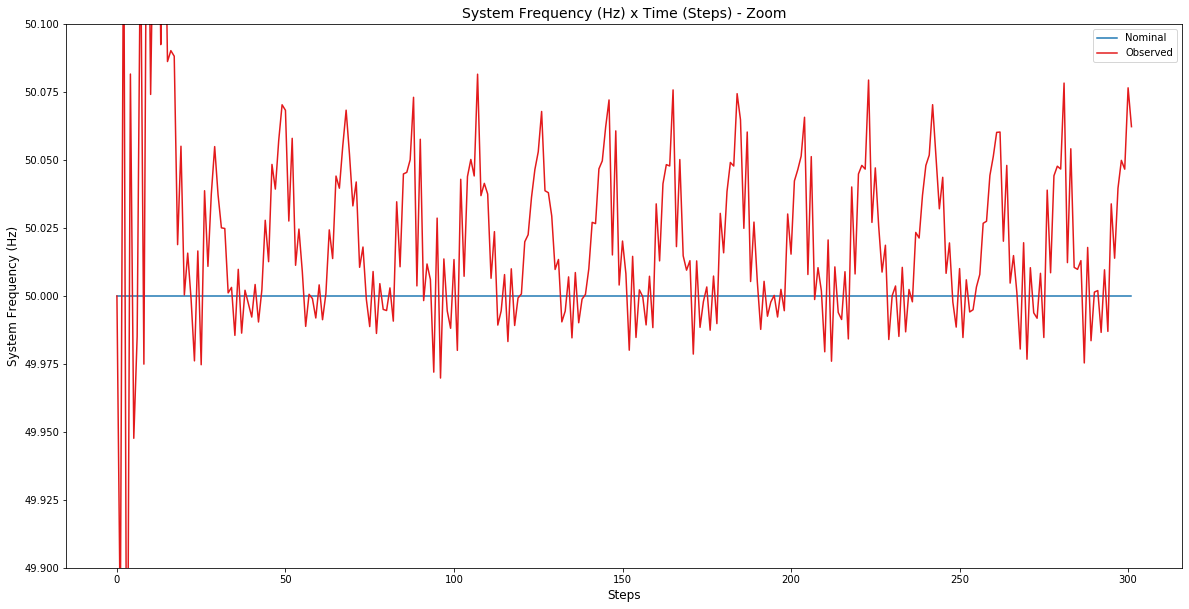

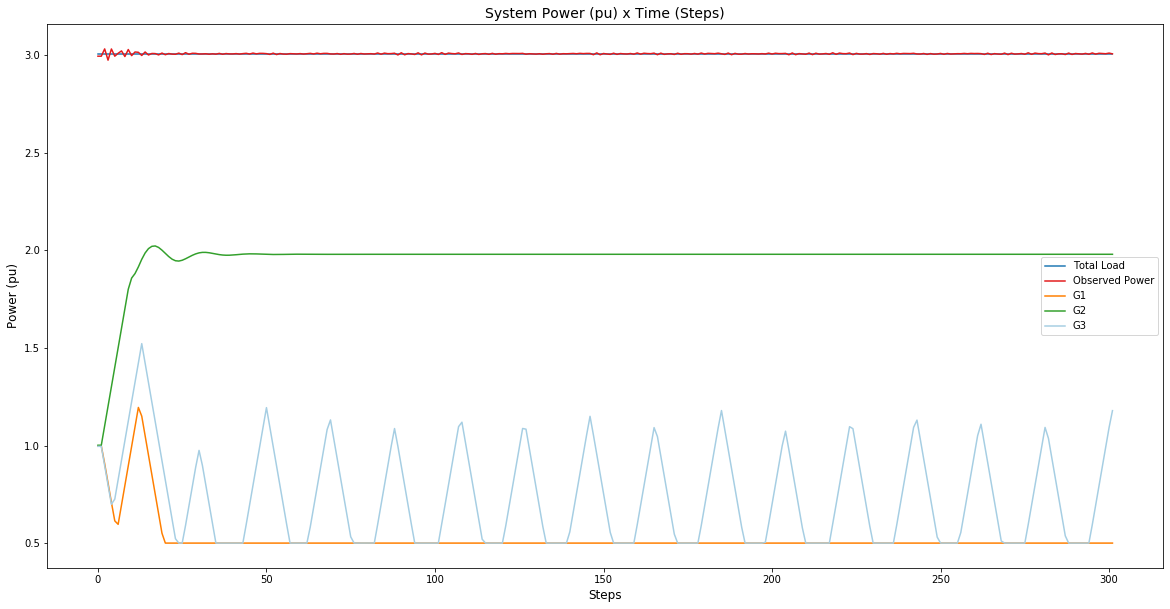

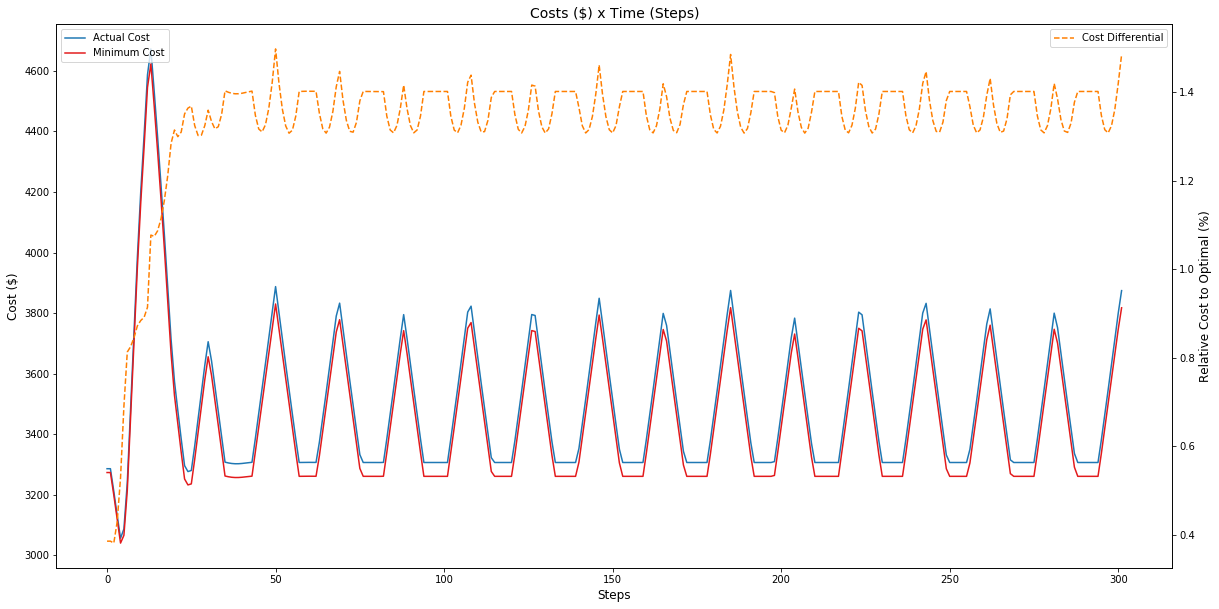

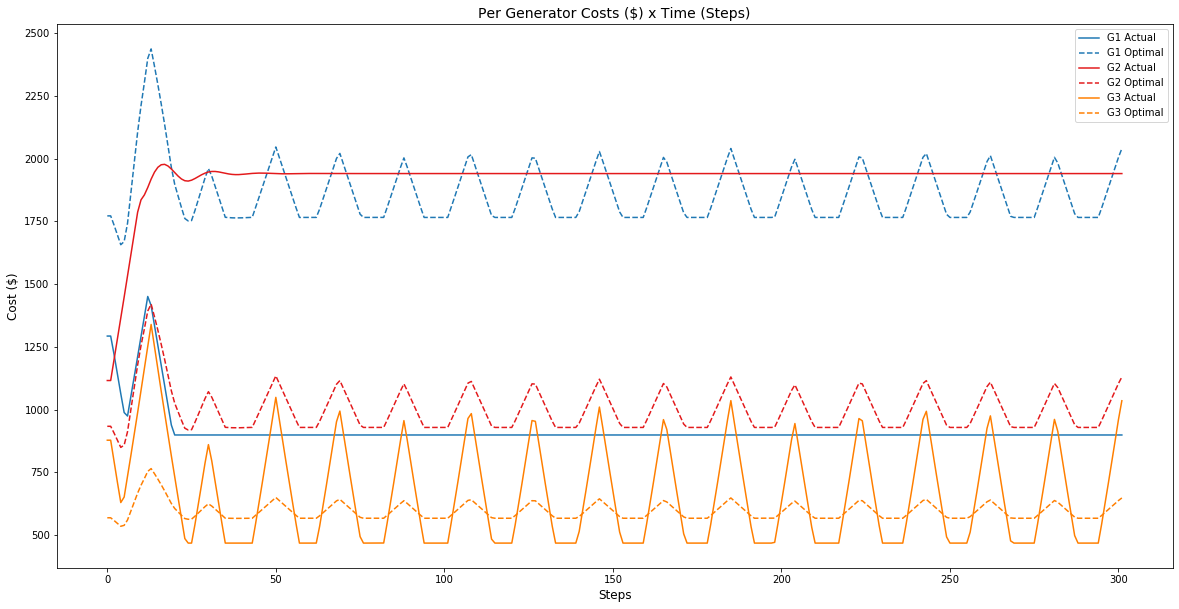

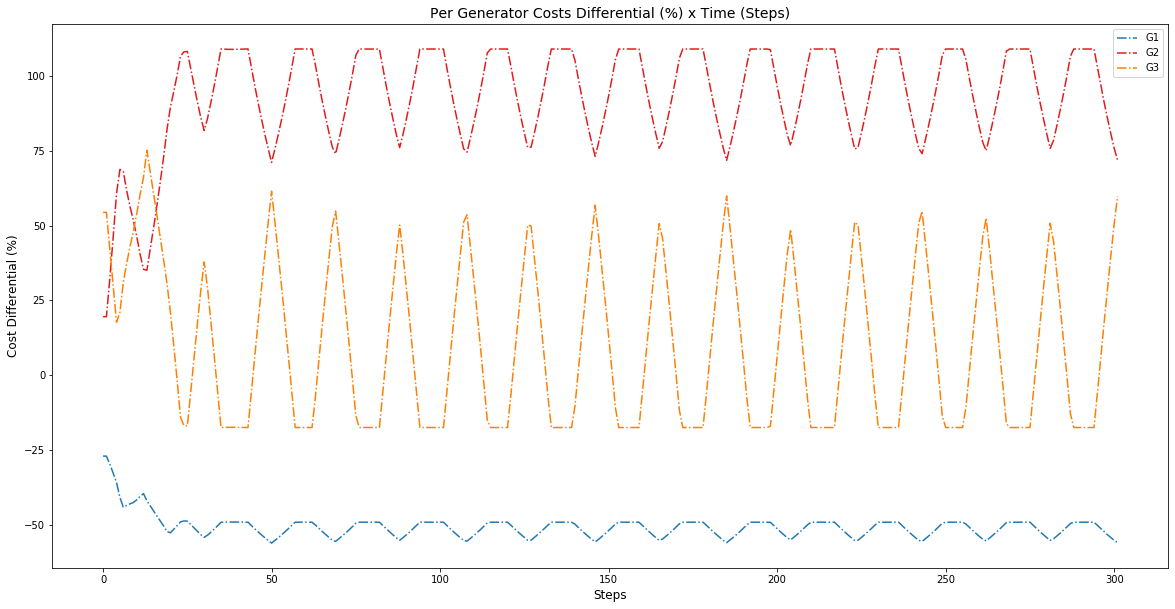

In [13]:
plotAll(electricalSystem.systemHistory)

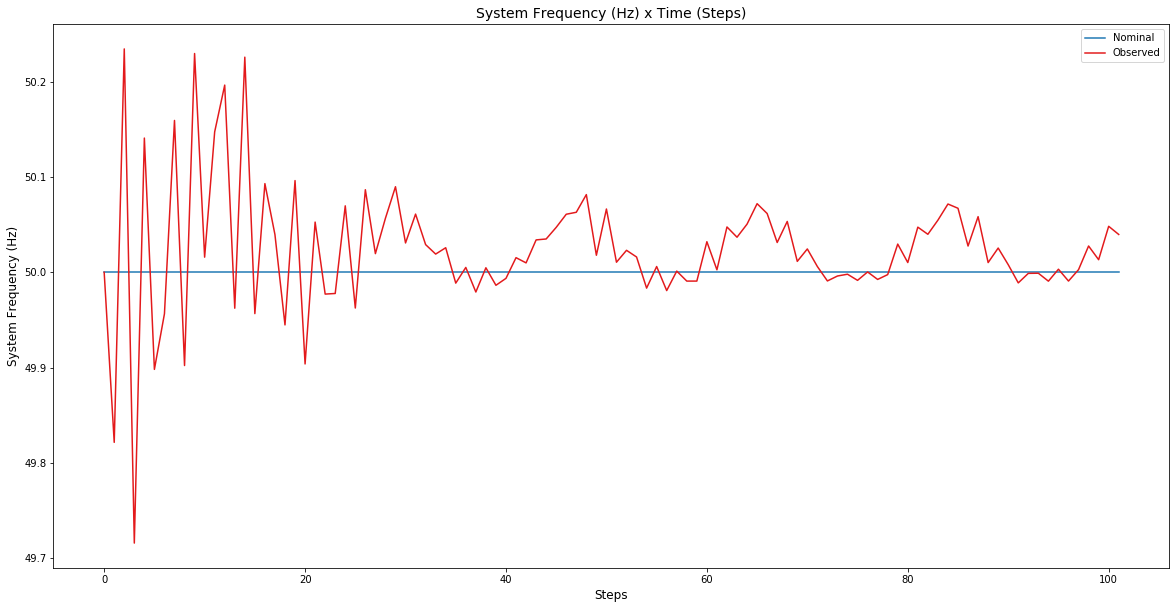

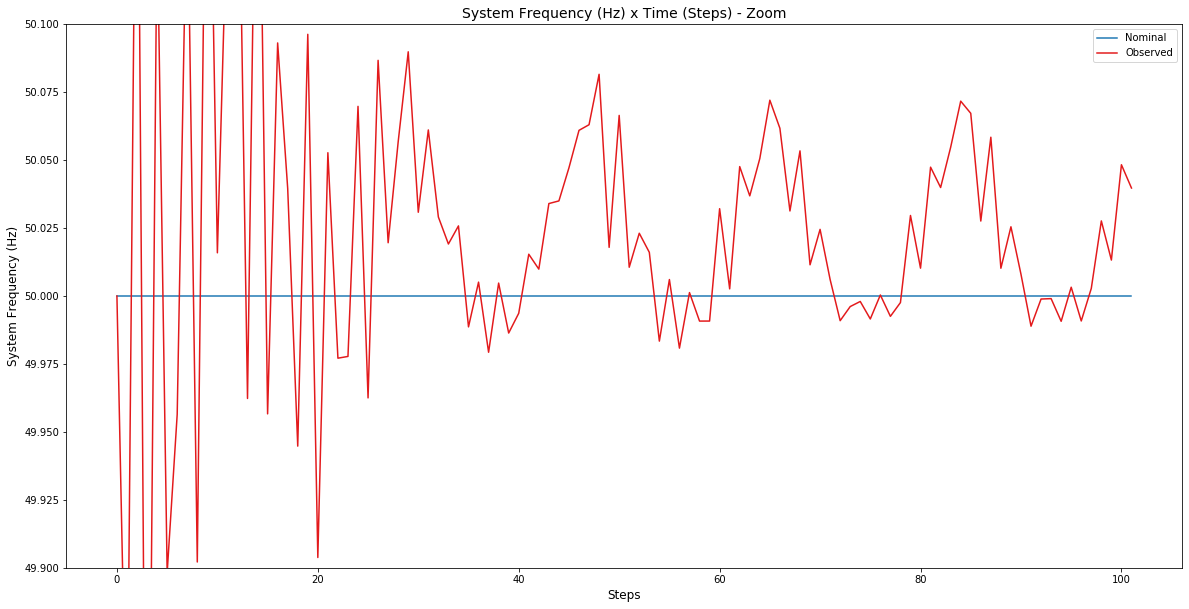

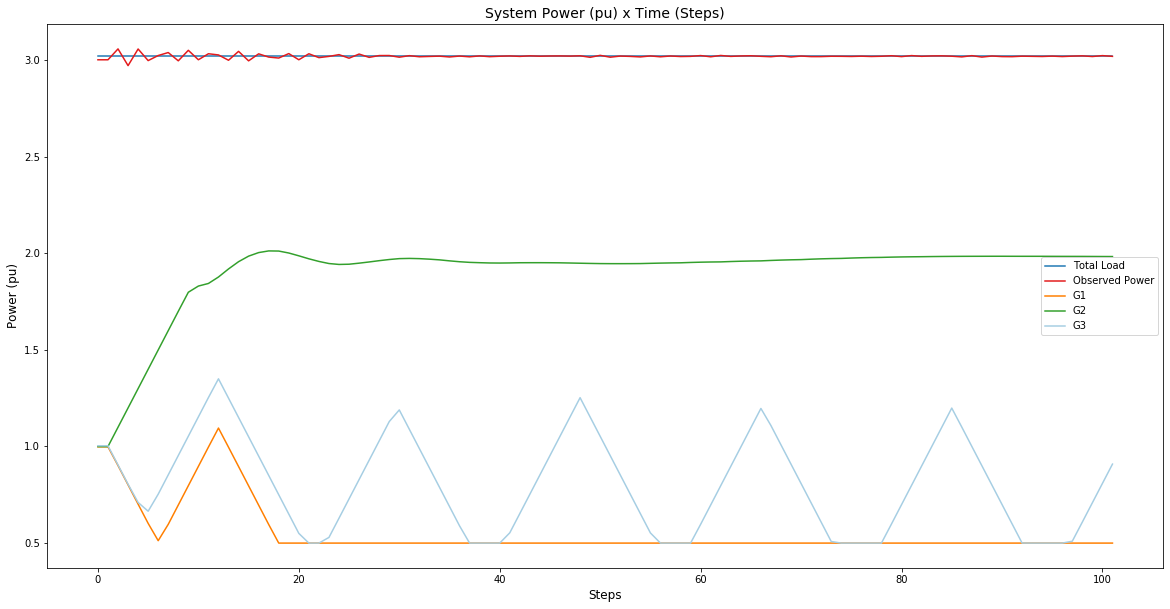

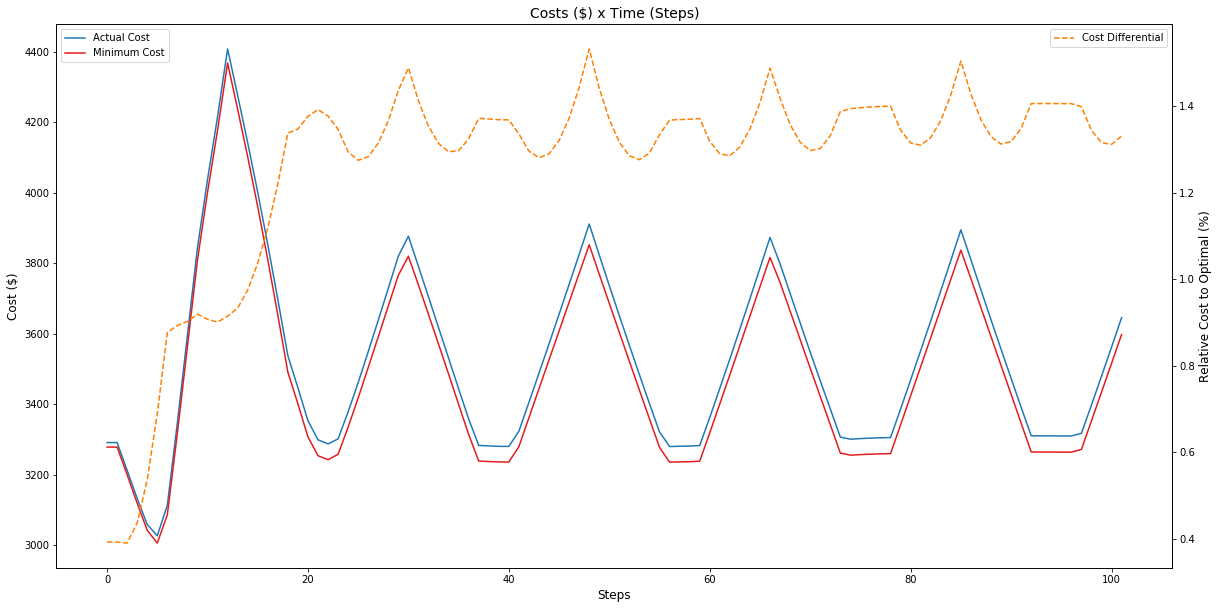

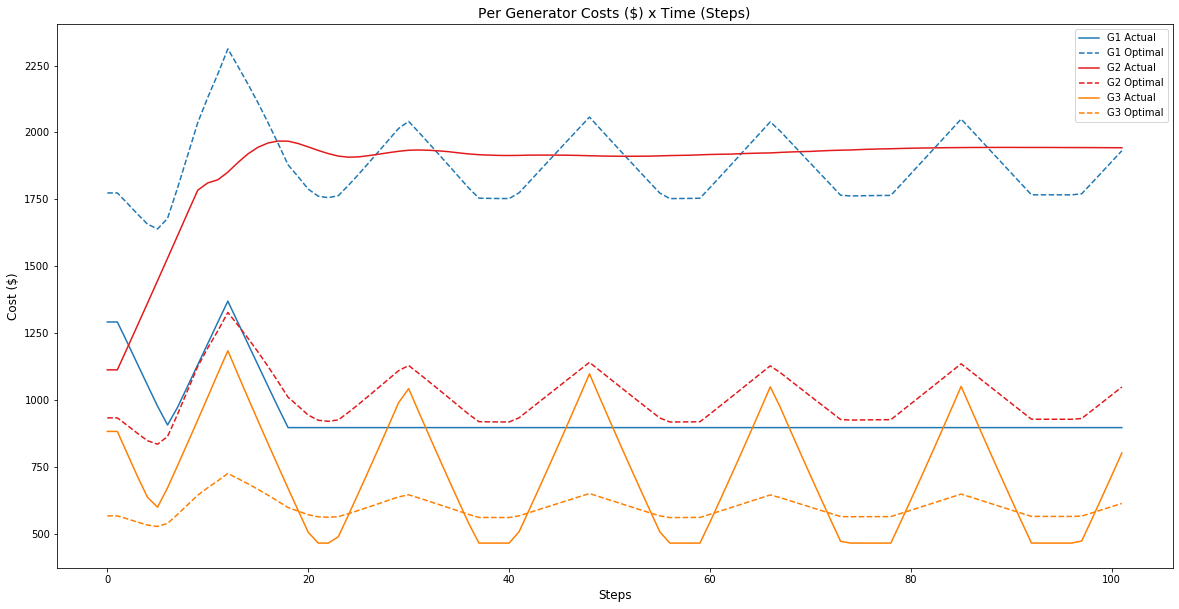

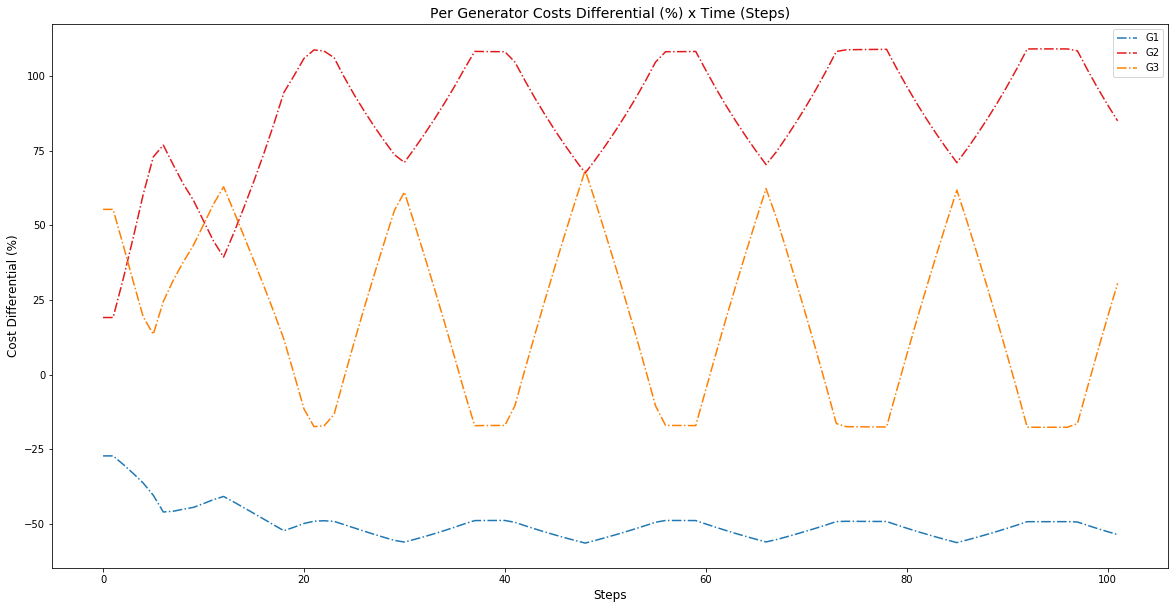

In [14]:
# # Show the last episode ran during training
from learning.learning_state import LearningState
plotAll(LearningState().episode.electricalSystem.systemHistory)

In [15]:
from learning.learning_state import LearningState
import numpy as np

rewList = LearningState().model.cummRewardList

In [16]:
LearningState().model.allRewards

[[{'cost': 0.9788364298851365,
   'output': 0.00023868454794465465,
   'total': 0.00023363313077889346},
  {'cost': 0.993992284844777,
   'output': 1.3205578293241948e-206,
   'total': 1.3126242940396155e-206},
  {'cost': 0.9928017925763369,
   'output': 5.9900809601383235e-165,
   'total': 5.946963114902713e-165},
  {'cost': 0.9678891472961959,
   'output': 1.85988120256028e-13,
   'total': 1.800158831218293e-13},
  {'cost': 0.9762888575185433,
   'output': 0.2120437475847893,
   'total': 0.20701594807350432},
  {'cost': 0.9918805729882895,
   'output': 5.585611954813388e-152,
   'total': 5.540259986230543e-152},
  {'cost': 0.936479262222588,
   'output': 2.2171806377633724e-207,
   'total': 2.07634368786685e-207},
  {'cost': 0.9532189125524583,
   'output': 3.901162739787812e-83,
   'total': 3.718662104510707e-83},
  {'cost': 0.9562930886317045,
   'output': 7.840886141492393e-62,
   'total': 7.498185225857288e-62},
  {'cost': 0.9498349877949981,
   'output': 4.200760056297815e-110,


TypeError: float() argument must be a string or a number, not 'dict'

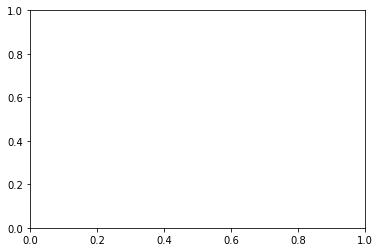

In [17]:
allRewards = LearningState().model.allRewards


for r in allRewards:
    plt.figure()
    plt.scatter(range(len(r)), r)
# sum(rewards)

In [ ]:
plt.scatter(range(len(rewList)), rewList)

In [ ]:
from plots.plot_constants import COLOR_PALETTE, FONT_SIZES

history = electricalSystem.systemHistory
# Get series to be plotted
stepsSeries = history.steps
loads = history.loads
totalLoadSeries = history.totalLoad
generators = history.generators
totalPowerSeries = history.totalPower

plt.figure(0)

# Declare colors to be used
colorTotalLoad = COLOR_PALETTE[0]
colorTotalPower = COLOR_PALETTE[1]
colorsIndividualNodes = COLOR_PALETTE[3:]

# Plot total power/load data
plt.plot(stepsSeries, totalLoadSeries, color=colorTotalLoad)
plt.plot(stepsSeries, totalPowerSeries, color=colorTotalPower)
legendFields = ['Total Load', 'Total Power']

# Multiple scenarios involve a single load, so we make it optional to plot that single load
if(False):
    for idx, loadId in enumerate(loads):
        # Since num loads is variable, colors may wrap around the palette
        loadColor = colorsIndividualNodes[idx % len(colorsIndividualNodes)]
        loadLegend = loadId
        loadSeries = loads[loadId]
        plt.plot(stepsSeries, loadSeries, color=loadColor, linestyle='--')
        legendFields.append(loadLegend)

for idx, generatorId in enumerate(generators):
    # Since num generators is variable, colors may wrap around the palette
    generatorColor = colorsIndividualNodes[idx % len(colorsIndividualNodes)]
    generatorLegend = generatorId
    generatorSeries = generators[generatorId]
    plt.plot(stepsSeries, generatorSeries, color=generatorColor)
    legendFields.append(generatorLegend)
    

summedPow = [x + y for x, y in zip(generators.get('G1'), generators.get('G2'))]
plt.plot(stepsSeries, summedPow, color=COLOR_PALETTE[2])
legendFields.append("Summed Pow")


plt.legend(legendFields)
plt.xlabel('Steps', fontsize=FONT_SIZES['AXIS_LABEL'])
plt.ylabel('Power (pu)', fontsize=FONT_SIZES['AXIS_LABEL'])

plt.title('System Power (pu) x Time (Steps)', fontsize=FONT_SIZES['TITLE'])

plt.show()